# Generate Phase-only Hologram (Stochastic Gradient Descent)

In [ ]:
import numpy as np
# import numpy.fft as fft
import matplotlib.pyplot as plt
from time import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft as fft
cm, mm, um, nm = 1e-2, 1e-3, 1e-6, 1e-9

In [ ]:
def pad_image(field, target_shape, padval=0, mode='constant'):
    """
        Pads a 2D complex field up to target_shape in size
        Padding is done such that when used with crop_image(), odd and even dimensions are handled correctly to properly undo the padding.

        field:          the field to be padded. May have as many leading dimensions as necessary (e.g., batch or channel dimensions)
        target_shape:   the 2D target output dimensions. If any dimensions are smaller than field, no padding is applied
        padval:         the real number value to pad by (default: 0)
        mode:           padding mode for numpy or torch
    """
    size_diff = np.array(target_shape) - np.array(field.shape[-2:])
    odd_dim = np.array(field.shape[-2:]) % 2

    # pad the dimensions that need to increase in size
    if (size_diff > 0).any():
        pad_total = np.maximum(size_diff, 0)
        pad_front = (pad_total + odd_dim) // 2
        pad_end = (pad_total + 1 - odd_dim) // 2
        pad_axes = [int(p) for tple in zip(pad_front[::-1], pad_end[::-1]) for p in tple]
        return nn.functional.pad(field, pad_axes, mode=mode, value=padval)

    else:
        return field

In [ ]:
def crop_image(field, target_shape):
    """
        Crops a 2D field, see pad_image() for detail
        No cropping is done if target_shape is already smaller than field
    """
    if target_shape is None:
        return field

    size_diff = np.array(field.shape[-2:]) - np.array(target_shape)
    odd_dim = np.array(field.shape[-2:]) % 2

    # crop dimensions that need to decrease in size
    if (size_diff > 0).any():
        crop_total = np.maximum(size_diff, 0)
        crop_front = (crop_total + 1 - odd_dim) // 2
        crop_end = (crop_total + odd_dim) // 2

        crop_slices = [slice(int(f), int(-e) if e else None) for f, e in zip(crop_front, crop_end)]
        return field[(..., *crop_slices)]
    else:
        return field

In [ ]:
def peak_signal_noise_ratio(target, output):
    rmse = np.sqrt(np.mean((target - output) ** 2))
    psnr = 20 * np.log10(1.0 / rmse)
    return psnr

# 1. Make aperture at image plane (z=0)

In [ ]:
def source_field(image_size, aperture_size, sampling_interval, num_samples):
    # Grid Coordinate
    x_point = np.linspace(-image_size/2, image_size/2 - sampling_interval, num=num_samples)
    y_point = np.linspace(-image_size/2, image_size/2 - sampling_interval, num=num_samples)
    grid_x, grid_y = np.meshgrid(x_point, y_point)

    # Aperture
    aperture = np.sqrt((grid_x ** 2) + (grid_y ** 2)) / (aperture_size / 2)
    aperture = np.exp(-np.power(aperture, 50))
    return aperture

# 2. Band-limited Angular Spectrum Method (BL-ASM)

In [ ]:
def propagation_blasm(u_in, feature_size, wavelength, z, linear_conv=True, return_kernel=False, precomputed_kernel=None):
    """
        Propagates the input field using the angular spectrum method

        Inputs
        ------
        u_in:           PyTorch Complex tensor (torch.cfloat) of size (num_images, 1, height, width) -- updated with PyTorch 1.7.0
        feature_size:   (height, width) of individual holographic features
        wavelength:     wavelength
        z:              propagation distance
        sampling:       extended band-limited ASM, default 1
        linear_conv:    if True, pad the input to obtain a linear convolution, default True
        return_H:       used for precomputing H or H_exp, ends the computation early and returns the desired variable
        precomped_H:    the precomputed value for H or H_exp

        Output
        ------
        tensor of size (num_images, 1, height, width)
    """

    # preprocess with padding for linear conv (Quadruple Extension)
    if linear_conv:
        input_resolution = u_in.size()[-2:]
        conv_size = [i * 2 for i in input_resolution]
        u_in = pad_image(u_in, conv_size, padval=0)

    if precomputed_kernel is None:
        field_resolution = u_in.size()                              # Resolution of input field [batch, channel, height, width]
        num_y, num_x = field_resolution[-2], field_resolution[-1]   # Number of pixels
        dy, dx = feature_size                                       # Sampling interval
        y, x = (dy * float(num_y), dx * float(num_x))               # Size of the input / slm field

        # frequency coordinates sampling
        fy = np.linspace(-1 / (2 * dy), 1 / (2 * dy), num_y)
        fx = np.linspace(-1 / (2 * dx), 1 / (2 * dx), num_x)
        fxx, fyy = np.meshgrid(fx, fy)

        # transfer function (band-limited ASM)
        kernel = np.exp(1j * 2 * np.pi * z * np.sqrt(1 / wavelength**2 - (fxx**2 + fyy**2)))
        dv, du = 1 / (num_y * dy), 1 / (num_x * dx)
        bly = 1 / (wavelength * np.sqrt((2 * z * dv)**2 + 1))
        blx = 1 / (wavelength * np.sqrt((2 * z * du)**2 + 1))
        bl_filter = (np.abs(fxx) < blx) & (np.abs(fyy) < bly)
        bl_kernel = torch.tensor(bl_filter * kernel).to(u_in.device)

    else:
        bl_kernel = precomputed_kernel

    if return_kernel:
        return bl_kernel

    u_in_fft = fft.fftshift(fft.fftn(fft.fftshift(u_in)))
    u_out_fft = bl_kernel * u_in_fft
    u_out = fft.fftshift(fft.ifftn(fft.fftshift(u_out_fft)))
    return crop_image(u_out, input_resolution) if linear_conv else u_out

# 3. Stochastic Gradient Descent (SGD algorithm)

1. Hologram plane에서 학습 가능한 파라미터로 이루어진 초기 랜덤 위상 $e^{i\phi_0}$을 생성한 후, image plane으로 전파한다.
2. Image plane으로 전파되어 복원된 이미지 $\hat{X}$과 Target image $X$를 비교한다. (Default L2)
3. Adam optimizer로 랜덤하게 생성된 위상을 업데이트 한다.

In [ ]:
def stochastic_gradient_descent(u_in, feature_size, wave_length, z, linear_conv=True,
                                num_iters=500, save_poh_interval=25, seed=7777):

    np.random.seed(seed)

    # Generate initial phase
    u_in = torch.tensor(u_in)
    init_phase = torch.tensor(np.random.rand(u_in.shape[-2], u_in.shape[-1]))
    holo_phase = init_phase.requires_grad_(True)  # set random phase learnable
    optim_vars = [{'params': holo_phase}]

    # kernel from hologram plane to image plane
    precomputed_kernel_b = propagation_blasm(torch.zeros_like(u_in), feature_size, wave_length, -z, linear_conv, return_kernel=True)
    precomputed_kernel_b.requires_grad = False

    # Loss function & Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(optim_vars, lr=8e-3)

    errors = []
    sgd_pohs = []
    start_time = time()
    for i in range(1, num_iters + 1):
        holo_field = torch.exp(1j * 2 * torch.pi * holo_phase)

        # Propagate Phase-only hologram from hologram plane to image plane
        recon_field = propagation_blasm(holo_field, feature_size, wave_length, -z, linear_conv, precomputed_kernel=precomputed_kernel_b)

        # Update phase with back-propagation algorithm
        optimizer.zero_grad()
        recon = torch.abs(recon_field)
        recon = (recon - torch.amin(recon)) / (torch.amax(recon) - torch.amin(recon))
        loss = criterion(torch.abs(recon_field), u_in)
        loss.backward()
        optimizer.step()

        if i % save_poh_interval == 0:
            errors.append(loss.item())
            sgd_pohs.append(holo_field)
            print(f'{i} iters loss: {loss.item():.6f}, {(time() - start_time):.6f}s')

    return errors, sgd_pohs

In [ ]:
# Make aperture at image plane (z=0)
num_samples = 1000
sampling_interval = 10 * um
image_size = num_samples * sampling_interval
aperture_size = 1 * mm
source = source_field(image_size, aperture_size, sampling_interval, num_samples)

# fixed
feature_size = (sampling_interval, sampling_interval)

# experiment
wave_length = 633 * nm
prop_dist = [40 * cm]
visualization_title = [f'Propagation {z}m' for z in prop_dist]

# Generate Phase-only hologram with gs-algorithm
num_iters = 200
save_poh_interval = 25
errors = []
sgd_pohs = []

for z in prop_dist:
    result = stochastic_gradient_descent(
        source, feature_size, wave_length, z, True,
        num_iters=num_iters, save_poh_interval=save_poh_interval
    )

    errors.append(result[0])
    sgd_pohs.append(result[1])

25 iters loss: 0.005801, 9.244236s
50 iters loss: 0.000815, 18.458097s
75 iters loss: 0.000383, 27.776662s
100 iters loss: 0.000312, 37.043402s
125 iters loss: 0.000282, 46.214162s
150 iters loss: 0.000269, 55.806801s
175 iters loss: 0.000261, 65.359131s
200 iters loss: 0.000254, 74.857055s


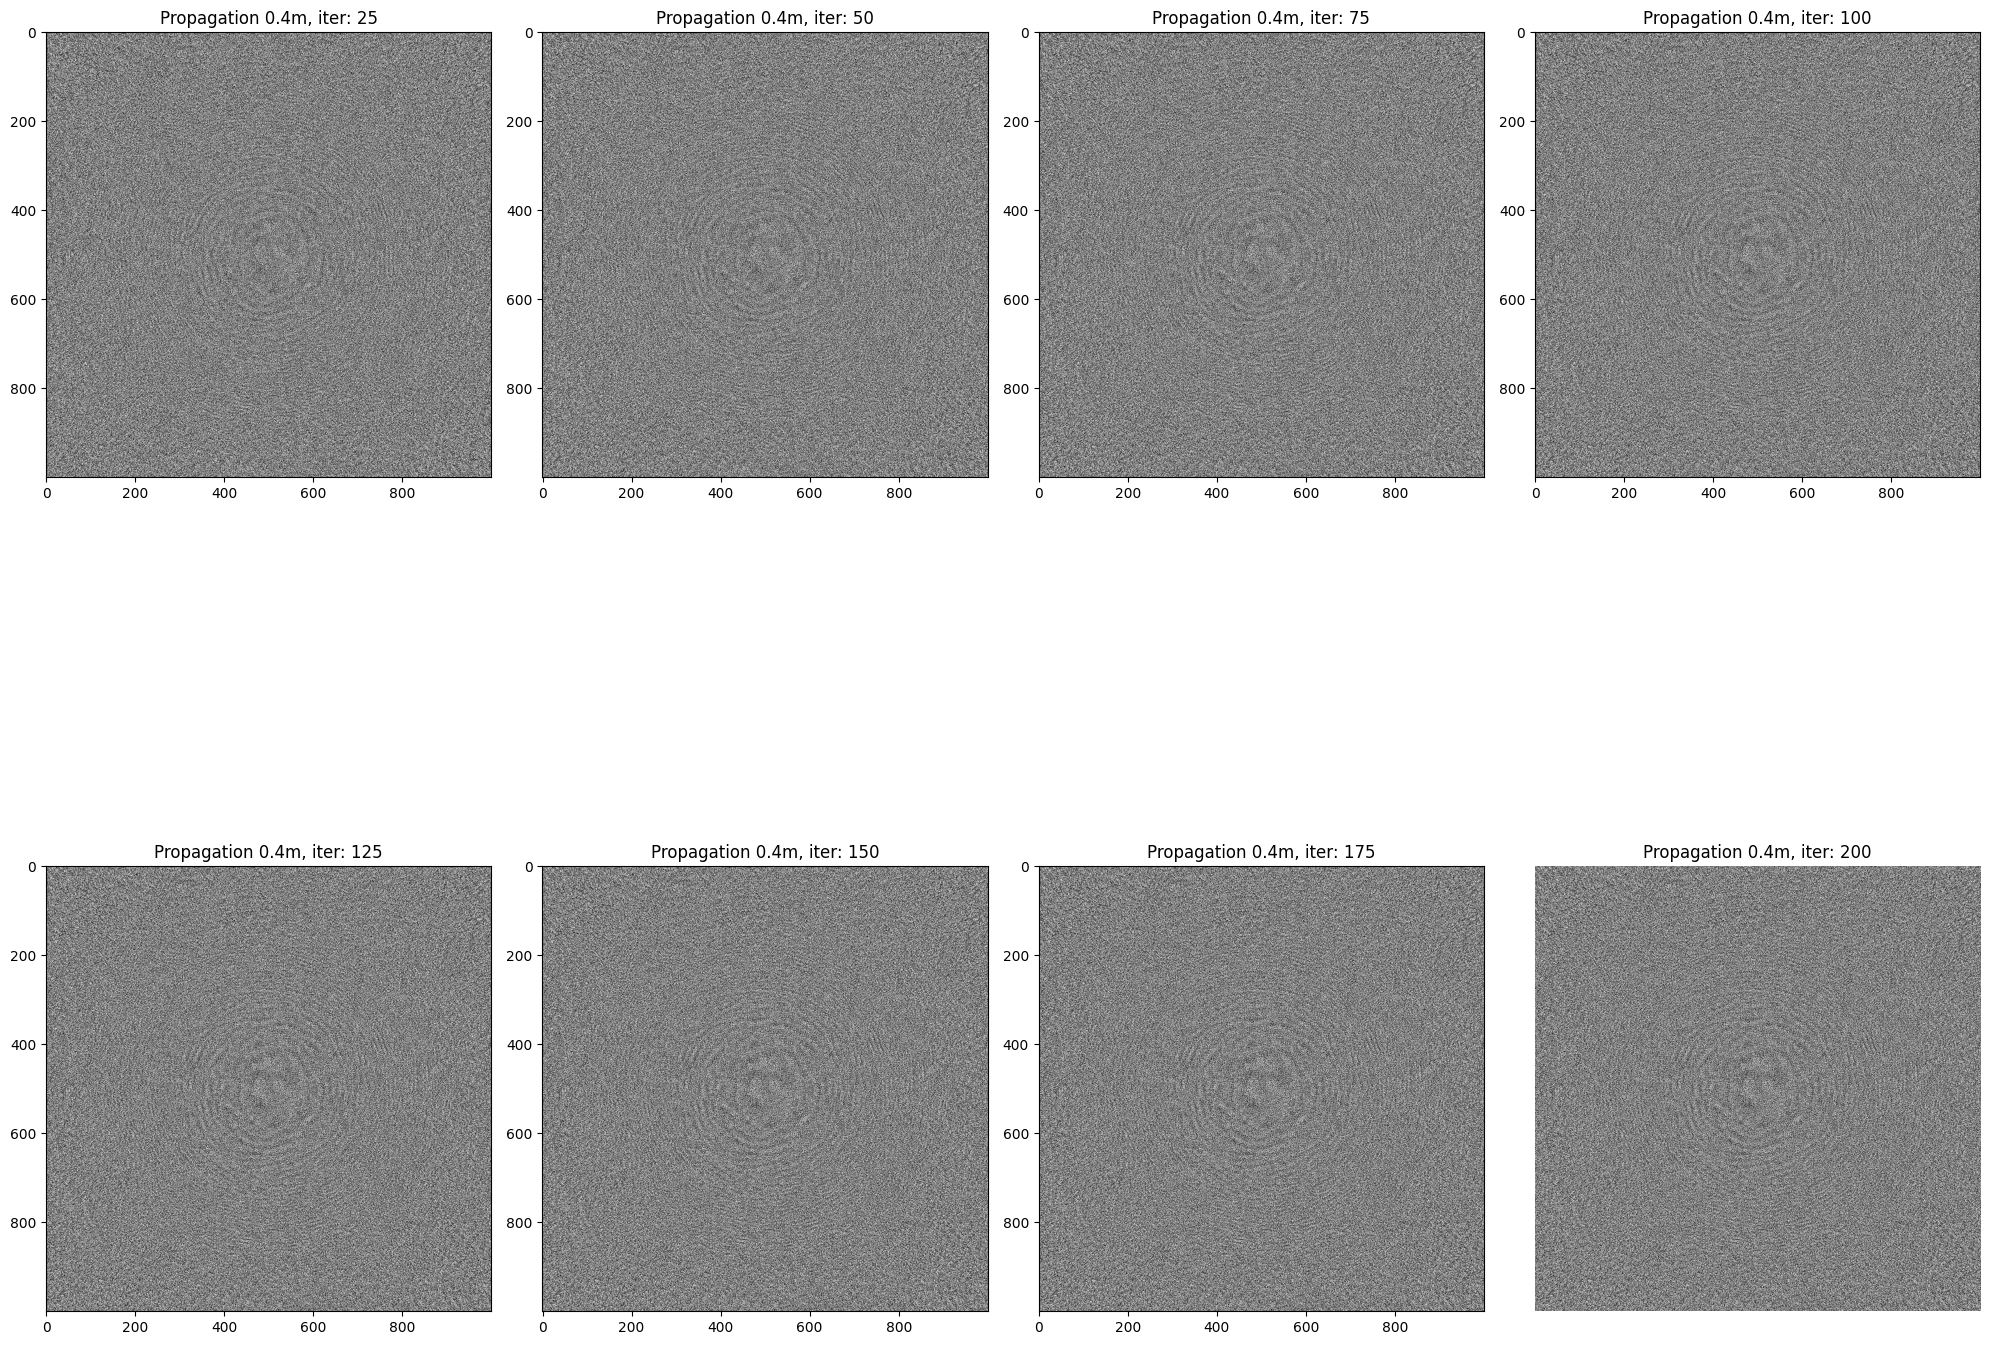

In [ ]:
visualization_title = [
    f'Propagation {z}m, iter: {iteration * 25}'
    for z in prop_dist
    for iteration in range(1, 1 + len(sgd_pohs[0]))
]

plt.figure(figsize=(20, 20))
for i, sgd_poh in enumerate(sgd_pohs[0][:]):
    plt.subplot(2, 4, i + 1)
    plt.imshow(np.angle(sgd_poh.detach().numpy()), cmap="gray")
    plt.title(visualization_title[i])

plt.axis('off')
plt.tight_layout()
plt.show()

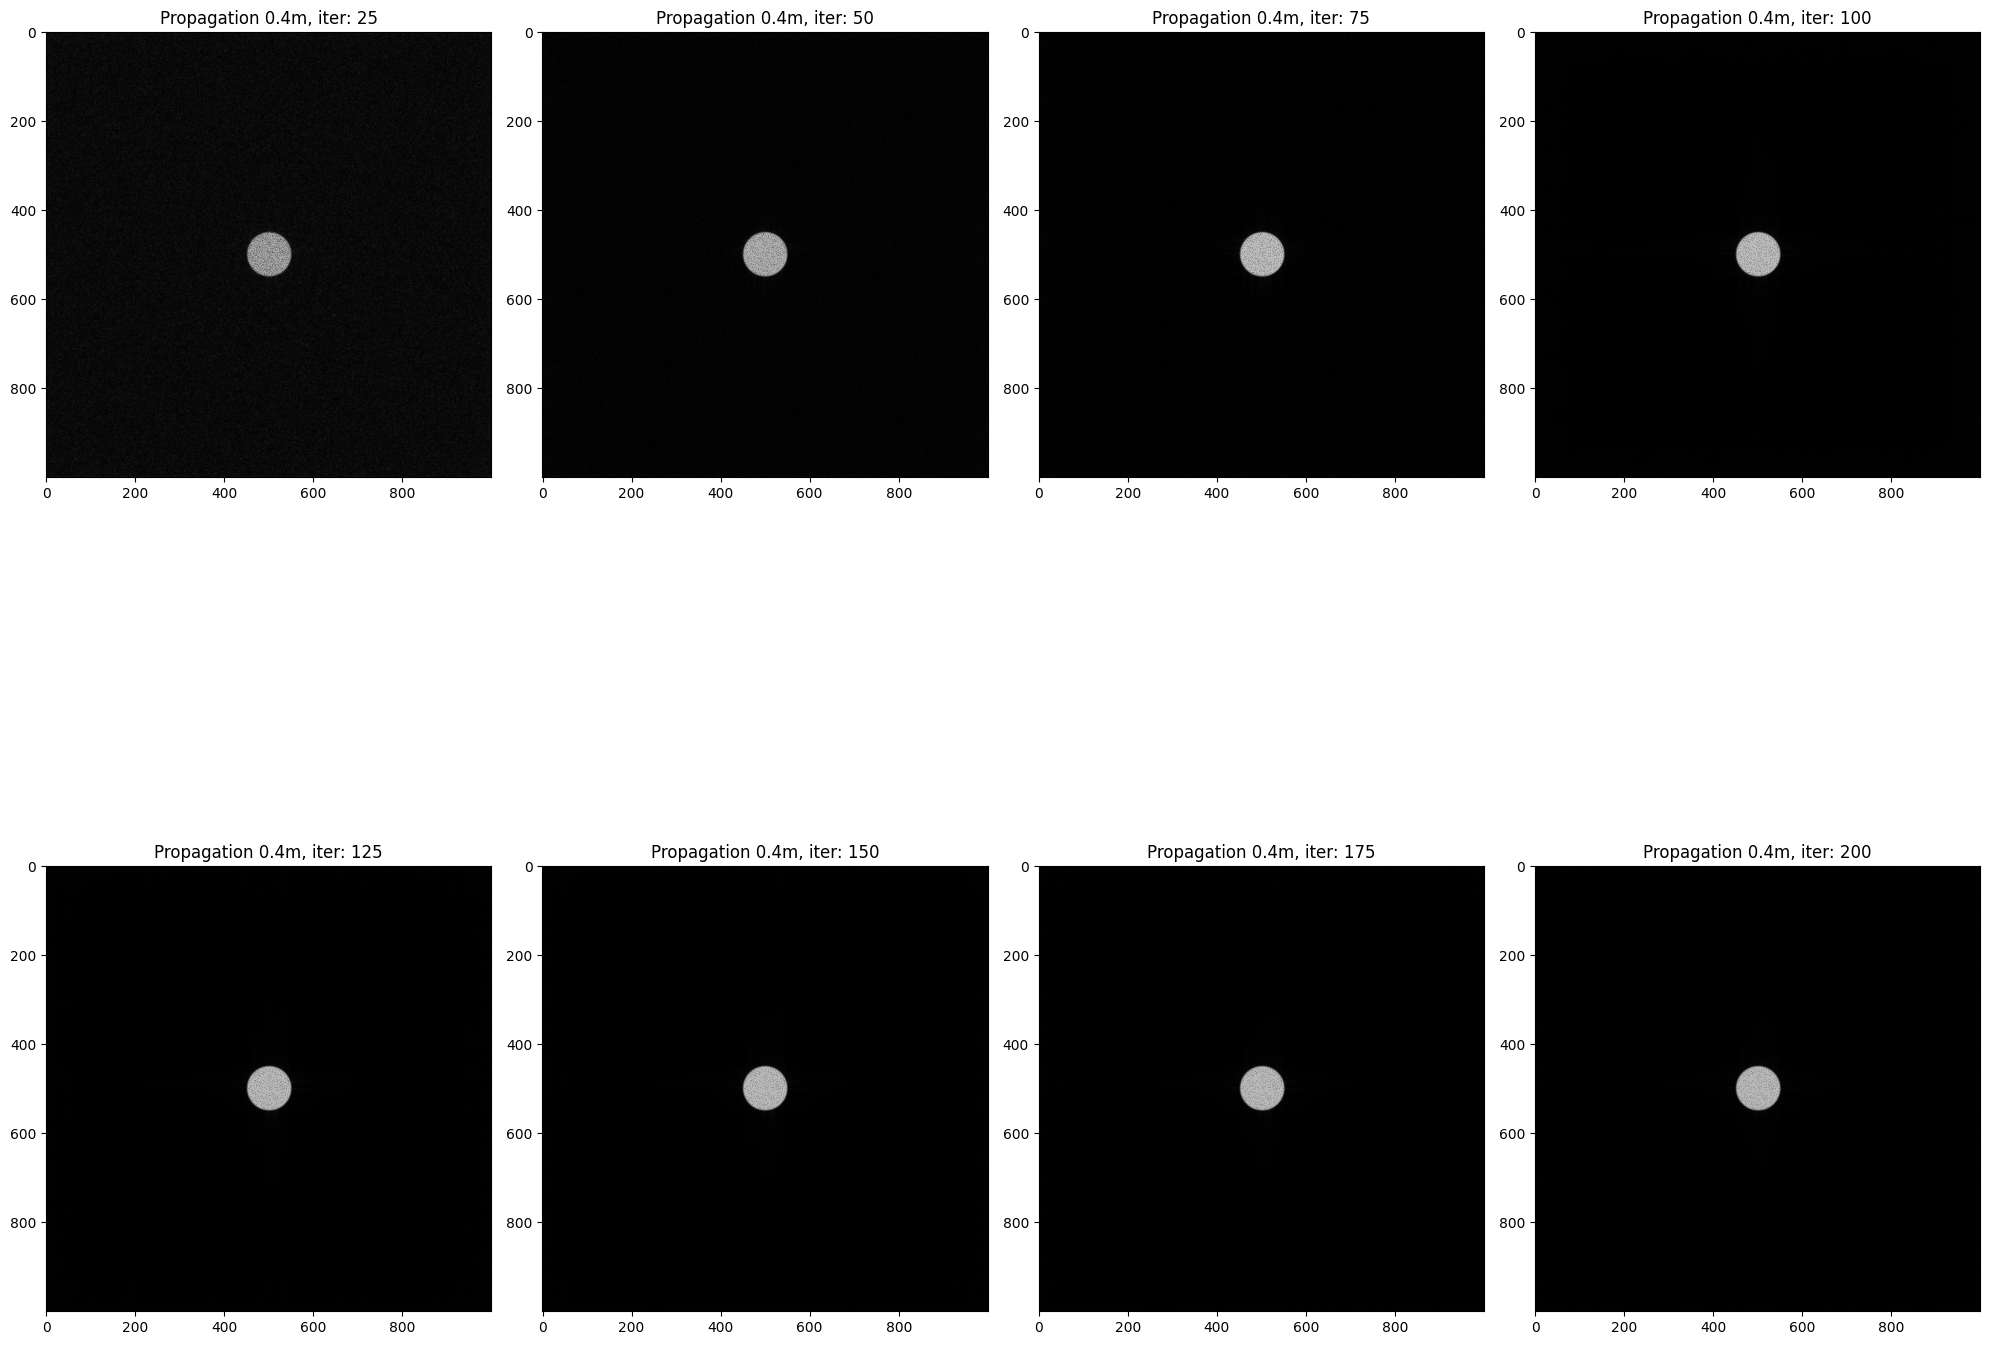

In [ ]:
slm_to_image_2 = []
for sgd_poh in sgd_pohs[0]:
    recon = propagation_blasm(sgd_poh, feature_size, wave_length, -prop_dist[0])

    recon = torch.abs(recon)
    recon = (recon - torch.amin(recon)) / (torch.amax(recon) - torch.amin(recon))
    slm_to_image_2.append(recon.detach().numpy())

visualization_title = [
    f'Propagation {z}m, iter: {iteration * 25}'
    for z in prop_dist
    for iteration in range(1, 1 + len(sgd_pohs[0]))
]

plt.figure(figsize=(20, 20))
for i, image in enumerate(slm_to_image_2[:10]):
    plt.subplot(2, 4, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(visualization_title[i])
plt.tight_layout()
plt.show()

In [ ]:
psnrs = []
for image in slm_to_image_2:
    psnrs.append([
        peak_signal_noise_ratio(source, image)
    ])

plt.figure(figsize=(10, 4))
plt.plot([iteration * 25 for iteration in range(1, 1 + len(sgd_pohs[0]))], psnrs, label='SGD algiorhtm')
plt.title('Numerical Reconstruction PSNR')
plt.xlabel('iteration')
plt.legend()
plt.show()

# 4. Stochastic Gradient Descent (SGD algorithm)

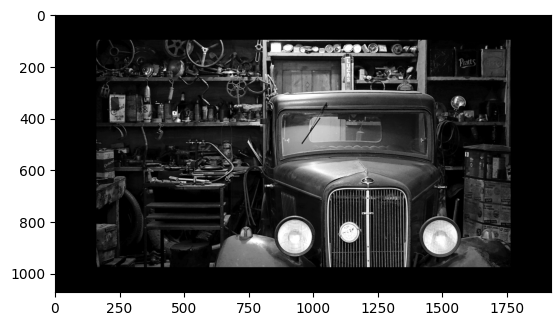

In [ ]:
import skimage.io as sio
img = sio.imread('sample1.png')[:, :, 1] / 255.
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
# fixed
img = sio.imread('sample1.png')[:, :, 1] / 255.
feature_size = (6.4 * um, 6.4 * um)

# experiment
wave_length = 530 * nm
prop_dist = [20 * cm]
visualization_title = [f'Propagation {z}m' for z in prop_dist]

# Generate Phase-only hologram with gs-algorithm
num_iters = 100
save_poh_interval = 20
errors = []
sgd_pohs = []

for z in prop_dist:
    result = stochastic_gradient_descent(
        img, feature_size, wave_length, z, True,
        num_iters=num_iters, save_poh_interval=save_poh_interval
    )

    errors.append(result[0])
    sgd_pohs.append(result[1])

20 iters loss: 0.015929, 15.683475s
40 iters loss: 0.004688, 31.476477s
60 iters loss: 0.002258, 47.242879s
80 iters loss: 0.001547, 63.350867s
100 iters loss: 0.001241, 79.000052s


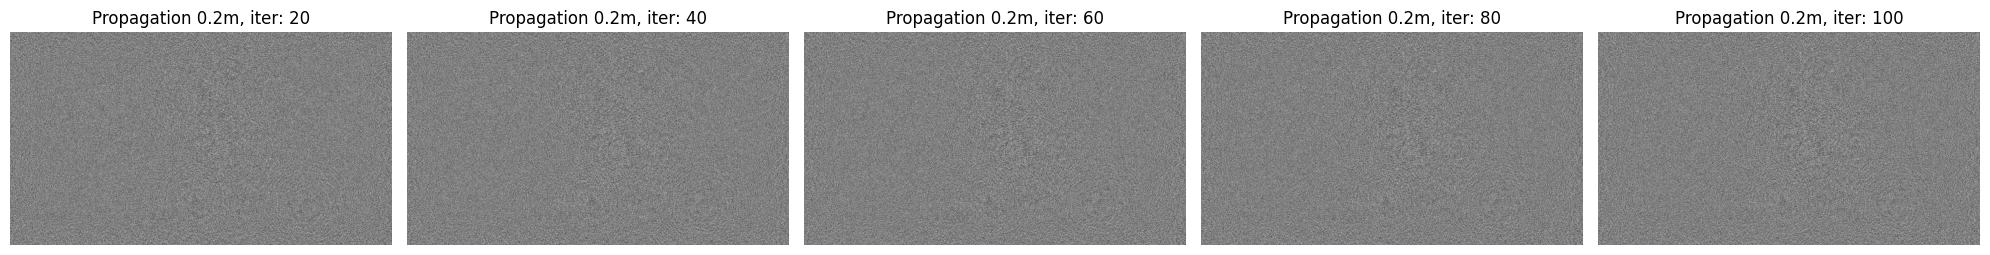

In [ ]:
visualization_title = [
    f'Propagation {z}m, iter: {iteration * save_poh_interval}'
    for z in prop_dist
    for iteration in range(1, 1 + len(sgd_pohs[0]))
]

plt.figure(figsize=(20, 20))
for i, sgd_poh in enumerate(sgd_pohs[0][:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.angle(sgd_poh.detach().numpy()), cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

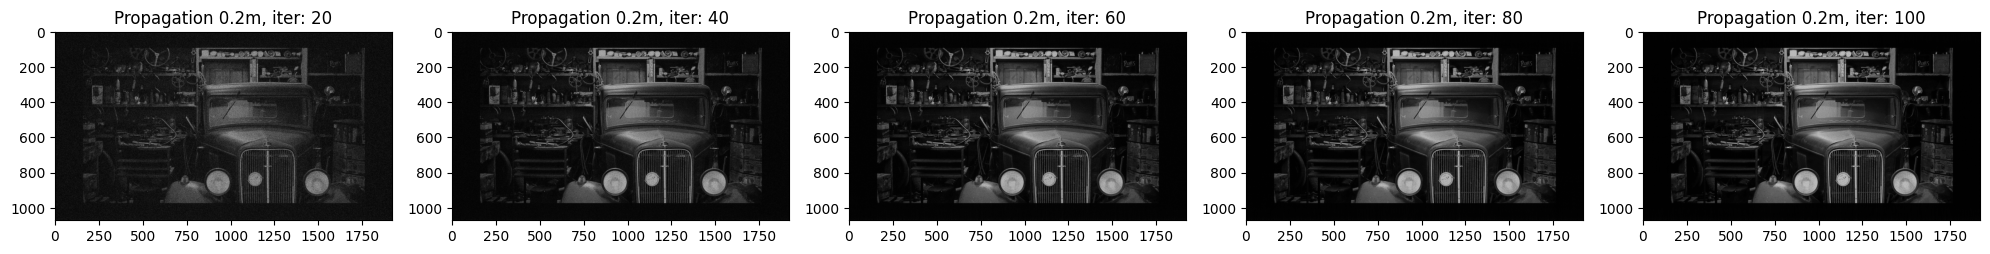

In [ ]:
slm_to_image_2 = []
for sgd_poh in sgd_pohs[0]:
    recon = propagation_blasm(sgd_poh, feature_size, wave_length, -prop_dist[0])

    recon = torch.abs(recon)
    recon = (recon - torch.amin(recon)) / (torch.amax(recon) - torch.amin(recon))
    slm_to_image_2.append(recon.detach().numpy())

visualization_title = [
    f'Propagation {z}m, iter: {iteration * save_poh_interval}'
    for z in prop_dist
    for iteration in range(1, 1 + len(sgd_pohs[0]))
]

plt.figure(figsize=(20, 20))
for i, image in enumerate(slm_to_image_2[:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(visualization_title[i])
plt.tight_layout()
plt.show()

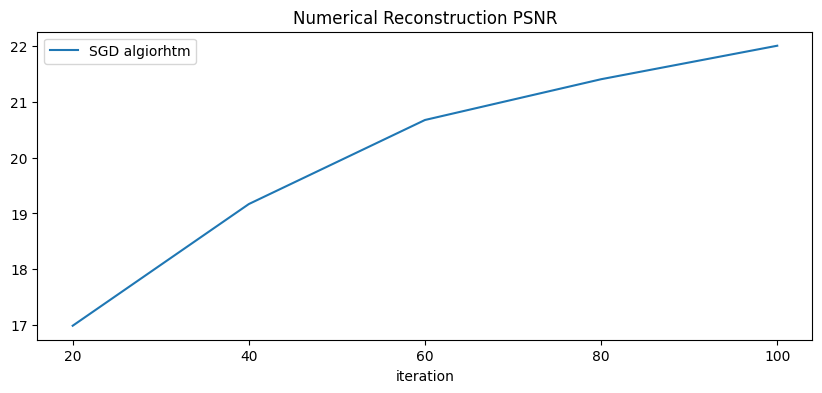

In [ ]:
psnrs = []
for image in slm_to_image_2:
    psnrs.append([
        peak_signal_noise_ratio(img, image)
    ])

x = [iteration * save_poh_interval for iteration in range(1, 1 + len(sgd_pohs[0]))]
plt.figure(figsize=(10, 4))
plt.plot(x, psnrs, label='SGD algiorhtm')
plt.title('Numerical Reconstruction PSNR')
plt.xticks(x)
plt.xlabel('iteration')
plt.legend()
plt.show()